# GP 408 Tutorial 7

### Question
I have given you bouguer anomaly data of the Cuddapah Basin which is the second-largest of the Proterozoic basins in India.

a) 	Compute the upward continuation of the Bouguer anomaly data for the Cuddapah Basin to a height of 25 km using the Fourier transform

b) .	Compute the downward continuation of the anomaly to a depth of 100 meters using the Fourier transfor

c) 3.	Apply a low-pass filter with an appropriate cutoff wavelength to both synthetic and field data. Analyze and discuss the effects of upward continuation and low-pass filtering on the results.


Drive link: https://drive.google.com/file/d/1vJsRPnjbrJ944jhUYXZFljUFUBc-co4u/view?usp=sharing
### Synthetic python code

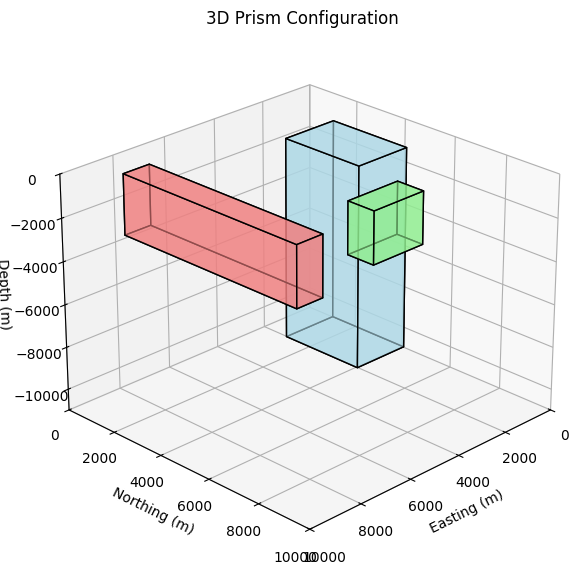

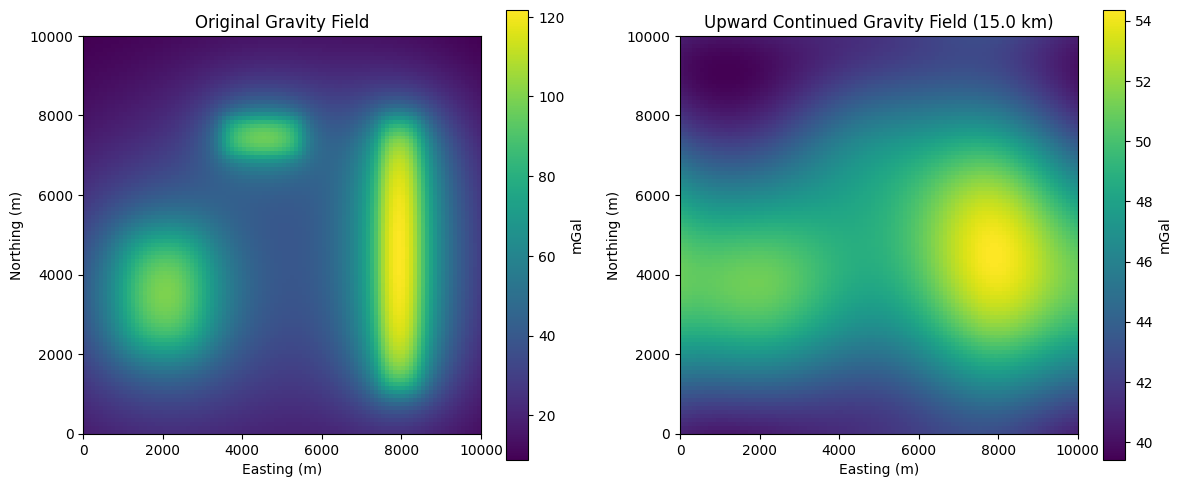

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import verde as vd
import harmonica as hm
from scipy.fftpack import fft2, ifft2, fftfreq

# Define the prism model [west, east, south, north, bottom, top]
prisms = [
    [1000, 3000, 2000, 5000, -10000, -500], #lightblue
    [3500, 5500, 7000, 8000, -2500, -100],  #light green
    [7500, 8500, 1000, 8000, -3000, -200],  # Red
]
densities = [2670, 3300, 4000]  # Densities of prisms

# ------ 3D PLOT OF PRISMS ------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

colors = ['lightblue', 'lightgreen', 'lightcoral']  # Different colors for prisms

for prism, color in zip(prisms, colors):
    west, east, south, north, bottom, top = prism

    # Define prism vertices
    vertices = np.array([
        [west, south, bottom], [east, south, bottom], [east, north, bottom], [west, north, bottom],  # Bottom
        [west, south, top], [east, south, top], [east, north, top], [west, north, top]  # Top
    ])

    # Define prism faces
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Side 1
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # Side 2
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Side 3
        [vertices[3], vertices[0], vertices[4], vertices[7]],  # Side 4
    ]

    # Create 3D polygon collection
    poly3d = Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=1, alpha=0.6)
    ax.add_collection3d(poly3d)

# Set labels and limits
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_zlabel("Depth (m)")
ax.set_title("3D Prism Configuration")

# Adjust axes limits based on the prisms' extents
ax.set_xlim(0, 10_000)
ax.set_ylim(0, 10_000)
ax.set_zlim(-11_000, 0)  # Depth axis (negative values go downward)

# Adjust viewing angle
ax.view_init(elev=25, azim=45)
plt.show()


# Generate a grid of coordinates
coordinates = vd.grid_coordinates(region=(0, 10e3, 0, 10e3), shape=(100, 100), extra_coords=0)

# Compute gravity field due to prisms
g_z = hm.prism_gravity(coordinates, prisms, densities, field="g_z")

# Convert to xarray grid
grid = vd.make_xarray_grid(coordinates, g_z, data_names="g_z", extra_coords_names="extra")

# Extract gravity field as a 2D numpy array
gravity_data = grid.g_z.values
ny, nx = gravity_data.shape
dx = (10e3) / nx  # Grid spacing in x-direction
dy = (10e3) / ny  # Grid spacing in y-direction

# Perform 2D FFT
fft_gravity = fft2(gravity_data)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude

# Define upward continuation height (in meters)
h = 15000  # meters

# Compute upward continuation filter
upward_filter = np.exp(-K * h)

# Apply the filter in the Fourier domain
fft_upward_continued = fft_gravity * upward_filter

# Perform inverse FFT to get back to spatial domain
gravity_upward = np.real(ifft2(fft_upward_continued))

# Convert back to xarray grid
grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(gravity_data, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='viridis')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_upward, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='viridis')
axes[1].set_title(f"Upward Continued Gravity Field ({h/1000} km)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()

In [3]:
from google.colab import files
uploaded=files.upload()

Saving Tutorial_7_cudapah_utm_csv.csv to Tutorial_7_cudapah_utm_csv.csv


In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from scipy.fftpack import fft2, ifft2, fftfreq

# File path
gravity_data=pd.read_csv("Tutorial_7_cudapah_utm_csv.csv")
# Load data

z = gravity_data["BA"]

# Extract coordinate information
longitude = gravity_data['longitude']
latitude = gravity_data['latitude']
#lon_grid, lat_grid = np.meshgrid(lon, lat,0.1)  # Correct meshgrid order

lon_min, lon_max=longitude.min(),longitude.max()
lat_min, lat_max=latitude.min(),latitude.max()
resolution=1000

lon_grid = np.linspace(lon_min, lon_max,resolution)
lat_grid =np.linspace(lat_min, lat_max,resolution)
lon_mesh,lat_mesh=np.meshgrid(lon_grid,lat_grid)

In [5]:
zi = griddata((gravity_data['longitude'], gravity_data['latitude']),gravity_data['BA'], (lon_mesh, lat_mesh), method='cubic')


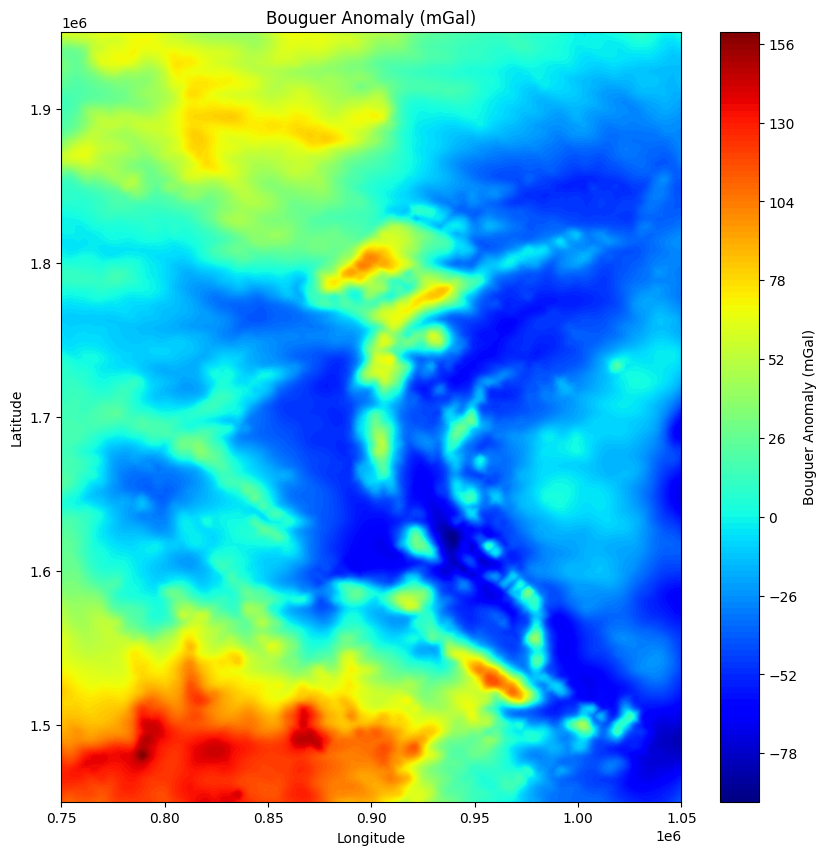

In [6]:
# Plot the grid data
fig, ax = plt.subplots(figsize=(10, 10))
#ax=plt.subplot(lon[3],lat[0])
# Filled contour plot
cp = ax.contourf(lon_grid, lat_grid, zi, cmap='jet', levels=150)  # Transpose z-values for correct orientation

cbar = plt.colorbar(cp, ax=ax, label='Bouguer Anomaly (mGal)')

# Labels and limits
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Bouguer Anomaly (mGal)')

# Show plot
plt.show()

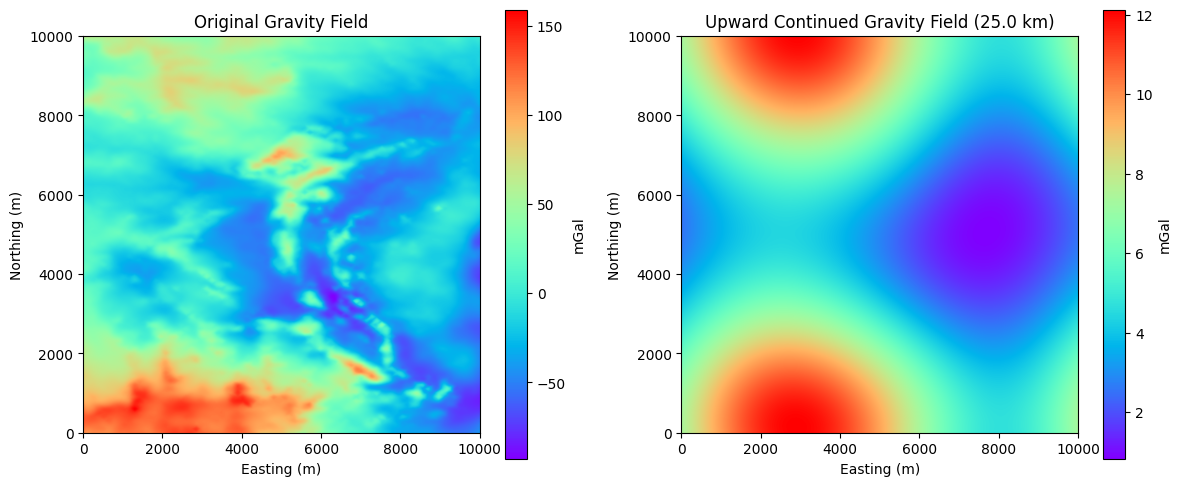

In [7]:
ny, nx = zi.shape
dx = (10e3) / nx  # Grid spacing in x-direction
dy = (10e3) / ny
fft_gravity = fft2(zi)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude
h = 25000  # meters

# Compute upward continuation filter
upward_filter = np.exp(-K * h)

# Apply the filter in the Fourier domain
fft_upward_continued = fft_gravity * upward_filter

# Perform inverse FFT to get back to spatial domain
gravity_upward = np.real(ifft2(fft_upward_continued))

# Convert back to xarray grid
#grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(zi, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='rainbow')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_upward, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='rainbow')
axes[1].set_title(f"Upward Continued Gravity Field ({h/1000} km)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()

In [8]:
dx

10.0

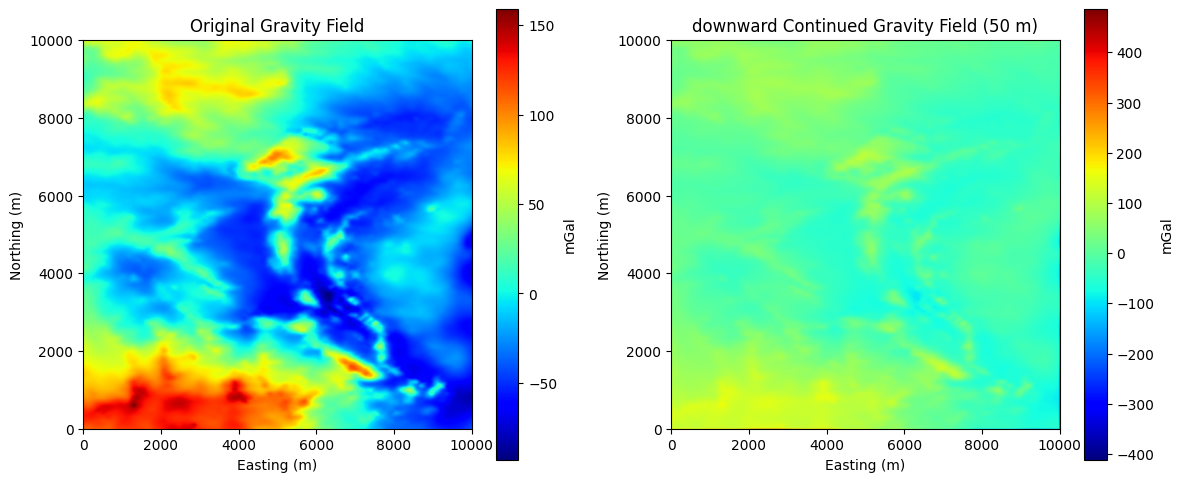

In [15]:
ny, nx = zi.shape
dx = (10e3) / nx  # Grid spacing in x-direction
dy = (10e3) / ny
fft_gravity = fft2(zi)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude
h = 50  # meters

# Compute upward continuation filter
upward_filter = np.exp(K * h)

# Apply the filter in the Fourier domain
fft_upward_continued = fft_gravity * upward_filter

# Perform inverse FFT to get back to spatial domain
gravity_upward = np.real(ifft2(fft_upward_continued))

# Convert back to xarray grid
#grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(zi, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_upward, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[1].set_title(f"downward Continued Gravity Field ({h} m)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()